# Solving the initial LP problem and simulating data

In [1]:
import sys
!{sys.executable}  -m pip install cplex
import cplex
from cplex import *
import pulp
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

  Using cached cplex-22.1.0.0-cp310-cp310-manylinux1_x86_64.whl (43.3 MB)


In [2]:
#checking that we have the solver needed and downloading it
solver_list =listSolvers(onlyAvailable = True)
solver = getSolver('CPLEX_CMD', timeLimit =  10)

#### Solving for the Simple Problem

In [3]:
vars = ['S3 Standard', 'S3 Standard-IA', 'S3 One Zone IA', 'S3 Glacier Instant Retrieval', 'S3 Glacier Flexible Retrieval', 'S3 Glacier Deep Archive']

# retrieval time in hrs

retrieval_time = {'S3 Standard': 0.001,
                  'S3 Standard-IA': 0.01,
                  'S3 One Zone IA': 0.1,
                  'S3 Glacier Instant Retrieval': 6,
                  'S3 Glacier Flexible Retrieval': 24, 
                  'S3 Glacier Deep Archive': 30}

# minimum storage duration

storage = {'S3 Standard': 0.5,
           'S3 Standard-IA': 30,
           'S3 One Zone IA': 30,
           'S3 Glacier Instant Retrieval': 90,
           'S3 Glacier Flexible Retrieval': 90,
           'S3 Glacier Deep Archive': 180}



# storage cost

cost = {'S3 Standard': 0.023,
        'S3 Standard-IA': 0.0125, 
        'S3 One Zone IA': 0.01, 
        'S3 Glacier Instant Retrieval': 0.04, 
        'S3 Glacier Flexible Retrieval': 0.0036,
        'S3 Glacier Deep Archive': 0.00099}

constraints = np.array([5000,30,3])

In [4]:
problem = LpProblem("Project", LpMinimize)
variables = LpVariable.dicts("Variables", vars, lowBound=0)
problem += lpSum([cost[i]*variables[i] for i in vars])

In [5]:
problem += lpSum([variables[i] for i in vars]) <= constraints[0]
problem += lpSum([variables[i] for i in vars]) >= constraints[0]
problem += lpSum([storage[i]*variables[i] for i in vars]/constraints[0]) <= constraints[1]
problem += lpSum([retrieval_time[i]*variables[i] for i in vars]/constraints[0]) <= constraints[2]

In [6]:
problem.solve(CPLEX_PY())

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve modified 12 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 2 rows, 4 columns, and 8 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 2 rows, 4 columns, and 8 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.00 sec. (0.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0       50.0000       50.0000        1    0.00%


1

In [7]:
print(LpStatus[problem.status])
for i in problem.variables():
    print("{0} = {1}".format(i.name, i.varValue))
print("z = %s"%(value(problem.objective)))

Optimal
Variables_S3_Glacier_Deep_Archive = 0.0
Variables_S3_Glacier_Flexible_Retrieval = 0.0
Variables_S3_Glacier_Instant_Retrieval = 0.0
Variables_S3_One_Zone_IA = 5000.0
Variables_S3_Standard = 0.0
Variables_S3_Standard_IA = 0.0
z = 50.0


## Simulating Data for 100 companies and solving:


In [8]:
%%capture
# set the seed so the same data is generated each time
np.random.seed(10)
n=100
# limit for retrieval rate data using the minimum and maximum possible rates
Rlim1 = np.random.uniform(low=0.001, high=0.1, size=n//2)
Rlim2 = np.random.uniform(low=0.01, high=30, size=n//2)
Rlim = np.append(Rlim1,Rlim2)
# limit for storage duration data using the minimum and maximum possible storage duration
Plim1 = np.random.uniform(low=0.5, high=30, size=n//2)
Plim2 = np.random.uniform(low=30, high=180, size=n//2)
Plim = np.append(Plim1,Plim2)
(np.random.shuffle(Rlim2))
(np.random.shuffle(Plim2))
#random amount of data that needs to be stored
S = np.random.uniform(low=1000, high=1000000, size=n)
X = np.zeros((6,n))
for k in range(0, n):
    problem = LpProblem("Project", LpMinimize)
    variables = LpVariable.dicts("Variables", vars, lowBound=0)
    problem += lpSum([cost[i]*variables[i] for i in vars])
    problem += lpSum([variables[i] for i in vars]) <= S[k]
    problem += lpSum([variables[i] for i in vars]) >= S[k]
    problem += lpSum([storage[i]*variables[i] for i in vars]/S[k]) <= Plim[k]
    problem += lpSum([retrieval_time[i]*variables[i] for i in vars]/S[k]) <= Rlim[k]
    problem.solve(CPLEX_PY())
    h = 0
    for j in problem.variables():
        print(j.varValue)
        X[h,k] = j.varValue
        h+=1    


### Visualize the Solution

In [9]:
# split the results
X1 = X[:, 0:25]
X2 = X[:, 25:50]
X3 = X[:, 50:75]
X4 = X[:, 75:100]

#assign the tier names to rows
row_names = [ 'S3 Glacier Deep Archive','S3 Glacier Flexible Retrieval','S3 Glacier Instant Retrieval', 'S3 One Zone IA', 'S3 Standard-IA','S3 Standard']

#create 4 dataframes for the data
X1 = pd.DataFrame(X1, index = row_names, columns = list(range(25)))
X2 = pd.DataFrame(X2, index = row_names, columns = list(range(25, 50)))
X3 = pd.DataFrame(X3, index = row_names, columns = list(range(50, 75)))
X4 = pd.DataFrame(X4, index = row_names, columns = list(range(75, 100)))

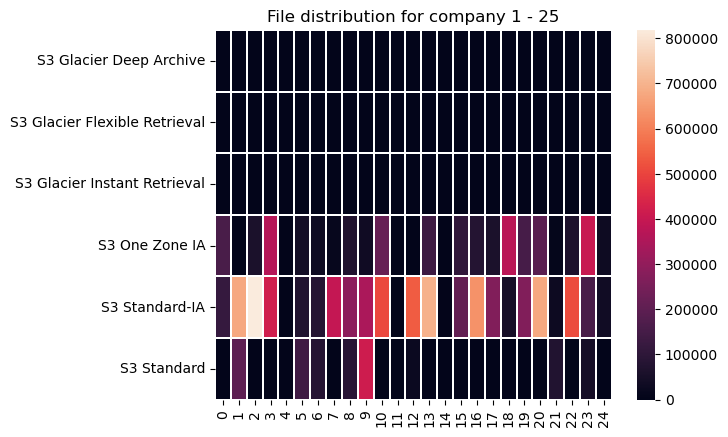

In [10]:
# plot the data
axs1 = sns.heatmap( X1 , linewidth = 0.01 , cmap = 'rocket' )
plt.title("File distribution for company 1 - 25")
plt.show()

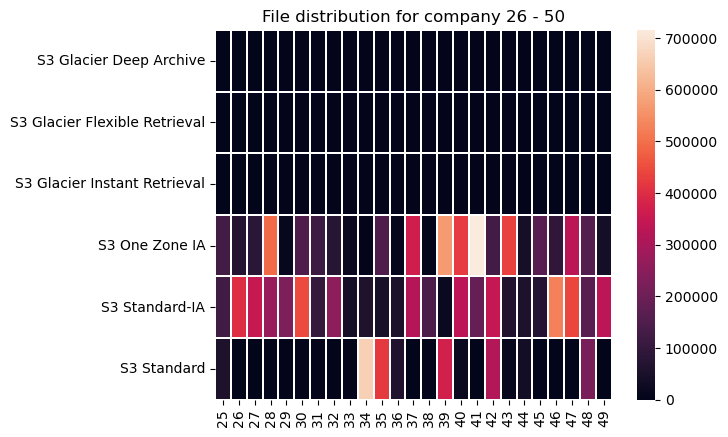

In [11]:
axs2 = sns.heatmap(X2 , linewidth = 0.01 , cmap = 'rocket' )
plt.title("File distribution for company 26 - 50")
plt.show()


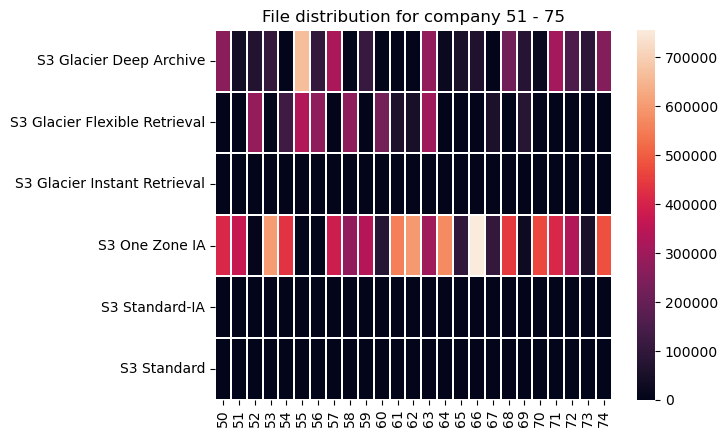

In [12]:
axs3 = sns.heatmap( X3 , linewidth = 0.01 , cmap = 'rocket' )
plt.title("File distribution for company 51 - 75")
plt.show()


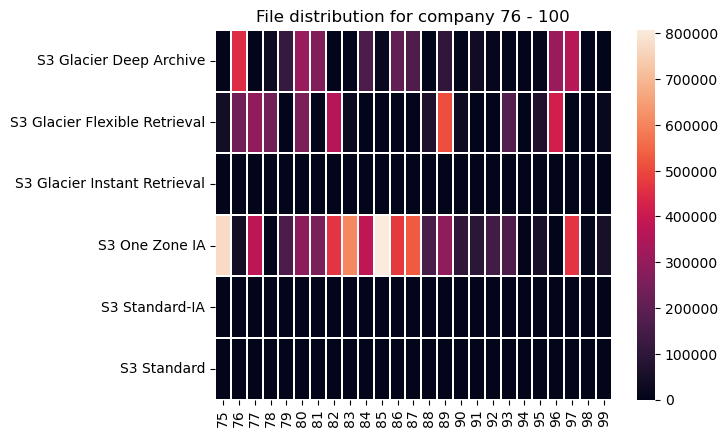

In [13]:
axs4 = sns.heatmap( X4 , linewidth = 0.01 , cmap = 'rocket' )
plt.title("File distribution for company 76 - 100")
plt.show()
